# Video Scene Detection based on Optimal Sequential Grouping

Some examples on synthetic data

In [1]:
from typing import Tuple

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from h_add import get_optimal_sequence_add
from h_nrm import get_optimal_sequence_nrm

%matplotlib inline

Helper functions:

In [2]:
class data_linewidth_plot():
    """
    Draws lines that could scale along with figure size
    Source: https://stackoverflow.com/questions/19394505/matplotlib-expand-the-line-with-specified-width-in-data-unit/42972469#42972469
    """
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y, **kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

        
def plot_distances_chart(distances: np.ndarray, scene_borders: np.ndarray, ax: matplotlib.axes.Axes) -> None:
    """
    Plot scene borders on top of the pairwise distances matrix

    :param distances: pairwise distances matrix
    :param scene_borders:
    """
    ax.imshow(distances, cmap='gray')
    for i, border in enumerate(scene_borders):
        data_linewidth_plot(x=[border, border], y=[0, len(distances)-1], ax=ax, linewidth=1, color='red', alpha=0.5)
        data_linewidth_plot(x=[0, len(distances)-1], y=[border, border], ax=ax, linewidth=1, color='red', alpha=0.5)

        
def get_synth_example(
    features_count: int,
    scenes_count: int,
    add_noise: bool = False,
    random_seed: int = 42
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic pairwise distance matrix for features_count shots and scenes_count scenes
    
    :param features_count: count of shots
    :param scenes_count: count of diagonal clusters represented scenes
    :param add_noise: if True, some normal noise will be added to distances
    :param random_seed: value for random numbers generator initialization
    :return: pairwise distance matrix and scene borders
    """
    synth_distances = np.ones((features_count, features_count)) + 4
    np.random.seed(random_seed)
    random_t = np.random.choice(range(2, features_count - 1), size=scenes_count-1, replace=False)
    random_t.sort()
    for i, t in enumerate(random_t):
        if i == 0:
            synth_distances[0:t, 0:t] = 0.5
        else:
            synth_distances[random_t[i - 1]:t, random_t[i - 1]:t] = 0.5
    synth_distances[random_t[-1]:features_count, random_t[-1]:features_count] = 0.5
    random_t = np.append(random_t, [features_count])
    if add_noise:
        synth_distances = synth_distances + np.random.normal(size=synth_distances.shape)

    np.fill_diagonal(synth_distances, 0)
    return synth_distances, random_t - 1

## Additive metric

Ideal synthetic example, when diagonal clusters clearly differ from the rest shots:

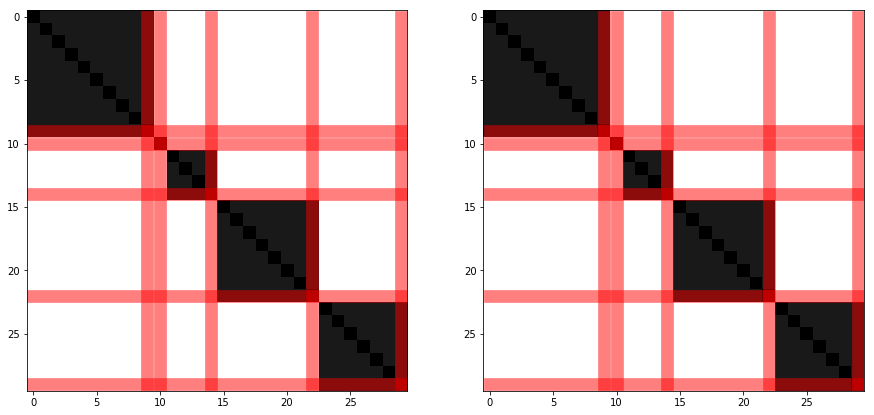

In [3]:
shots_count = 30
scenes_count = 5
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_add(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,15))
plot_distances_chart(distances, synth_scene_borders, axs[0])
plot_distances_chart(distances, optimal_scene_borders, axs[1])

Example with some normal noise:

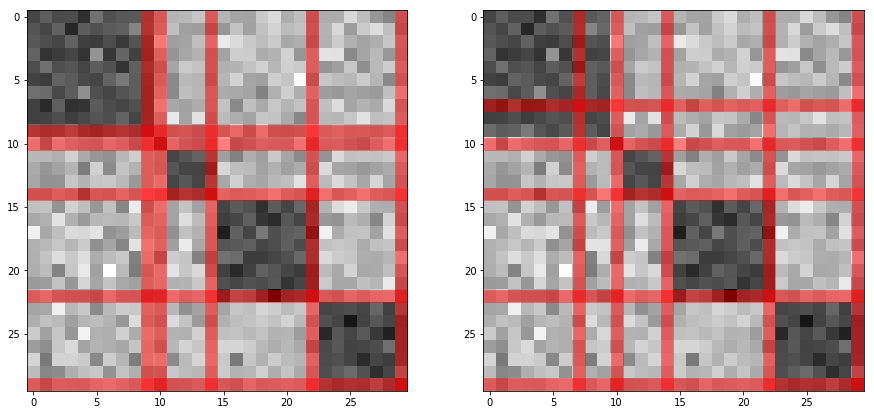

In [4]:
shots_count = 30
scenes_count = 5
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count, add_noise=True)
optimal_scene_borders = get_optimal_sequence_add(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,15))
plot_distances_chart(distances, synth_scene_borders, axs[0])
plot_distances_chart(distances, optimal_scene_borders, axs[1])

## Normalized metric

Ideal synthetic example, when diagonal clusters clearly differ from the rest shots:

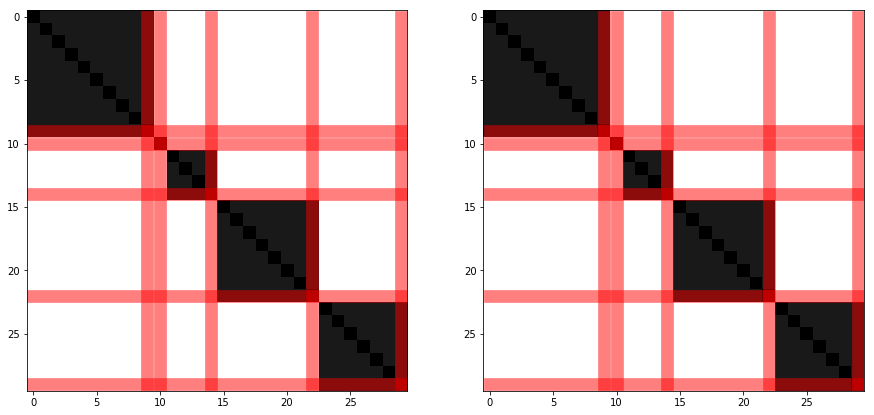

In [5]:
shots_count = 30
scenes_count = 5
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_nrm(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,15))
plot_distances_chart(distances, synth_scene_borders, axs[0])
plot_distances_chart(distances, optimal_scene_borders, axs[1])

Example with some normal noise:

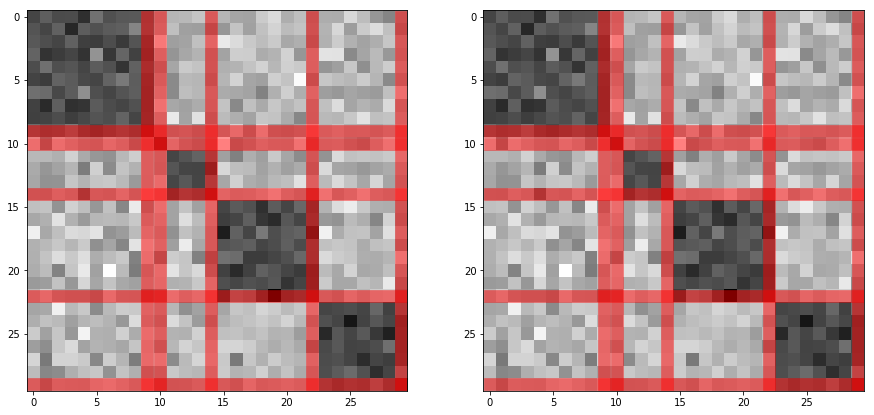

In [6]:
shots_count = 30
scenes_count = 5
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count, add_noise=True)
optimal_scene_borders = get_optimal_sequence_nrm(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,15))
plot_distances_chart(distances, synth_scene_borders, axs[0])
plot_distances_chart(distances, optimal_scene_borders, axs[1])

As you can see, Normalized Const Function works better with noized data.